In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from timeit import default_timer as timer


$\large\textbf{Part 1 : Initial Choice of } B^0$

Initially we can start by letiing $B^0 = I$    where, $I$ is the identity matrix

$\large\textbf{General Code} $

In [55]:
def evalf(x,n):
  assert type(x) is np.ndarray
  assert n >=2
  assert len(x) == n

  f = 0

  for i in range(n-1):
    f += 2*(x[i]**2 - x[i+1])**2 + (x[i]-1)**2

  return f



def evalg(x,n):
  assert type(x) is np.ndarray
  assert n >=2
  assert len(x) == n

  g = np.zeros(n)
  g[0] = 8*x[0]*(x[0]**2 - x[1]) + 2*(x[0]-1)

  for i in range(1,n-1):
    g[i] = -4*(x[i-1]**2 - x[i]) + 8*x[i]*(x[i]**2 - x[i+1]) + 2*(x[i]-1)

  g[n-1] = -4*(x[n-2]**2 - x[n-1])

  return g.reshape((n,1))


def evalh(x,n):
  assert type(x) is np.ndarray
  assert n >=2
  assert len(x) == n

  h = np.zeros((n,n))
  h[0][0] = 8*(x[0]**2 - x[1]) + 16*x[0]**2 + 2
  h[0][1] = -8*x[0]

  for i in range(1,n-1):
    h[i][i] = 4 + 16*x[i]**2 + 8*(x[i]**2 - x[i+1]) +2
    h[i][i+1] = -8*x[i]
    h[i][i-1] = h[i-1][i]

  h[n-1][n-2] = h[n-2][n-1]
  h[n-1][n-1] = 4

  return h




def compute_steplength_backtracking_scaled_direction(x,n ,gradf, direction, alpha_start, rho, gamma): #add appropriate arguments to the function 
  assert type(x) is np.ndarray and len(gradf) == n 
  assert type(gradf) is np.ndarray and len(gradf) == n 
  assert type(direction) is np.ndarray and len(direction) == n
  assert type(alpha_start) is float and alpha_start>=0. 
  assert type(rho) is float and rho>=0.
  assert type(gamma) is float and gamma>=0. 

  alpha = alpha_start
  p = -gradf

  while (evalf(x + alpha*np.matmul(direction,p),n) > (evalf(x,n) + gamma * alpha * np.matmul(gradf.T, np.matmul(direction, p))) ):
    alpha = alpha*rho
 
  return alpha





#line search type 
CONSTANT_STEP_LENGTH = 3
BACKTRACKING_LINE_SEARCH = 2
EXACT_LINE_SEARCH = 1


def find_minimizer_Newtonmethod(start_x, n, tol, line_search_type, *args):
  #Input: start_x is a numpy array of size n, tol denotes the tolerance and is a positive float value
  assert type(start_x) is np.ndarray #do not allow arbitrary type arguments 
  assert len(start_x) == n #do not allow arbitrary size arguments 
  assert type(tol) is float and tol>=0 
  
  x = start_x.reshape((n,1))
  g_x = evalg(x,n)
  

  if line_search_type == BACKTRACKING_LINE_SEARCH:
    if args is None:
      err_msg = 'Line search type: BACKTRACKING_LINE_SEARCH, but did not receive any args. Please check!'
      raise ValueError(err_msg)
    elif len(args)<3 :
      err_msg = 'Line search type: BACKTRACKING_LINE_SEARCH, but did not receive three args. Please check!'
      raise ValueError(err_msg)
    else:
      alpha_start = float(args[0])
      rho = float(args[1])
      gamma = float(args[2])
  k = 0
  
  #print('iter:',k,  ' f(x):', evalf(x,n), ' gradient norm:', np.linalg.norm(g_x))

  while (np.linalg.norm(g_x) > tol):

    d = np.linalg.inv(evalh(x,n))

    if line_search_type == BACKTRACKING_LINE_SEARCH:
      step_length = compute_steplength_backtracking_scaled_direction(x,n,g_x, d , alpha_start,rho, gamma)
 
    elif line_search_type == CONSTANT_STEP_LENGTH: 
      step_length = 0.4
 
    else:  
      raise ValueError('Line search type unknown. Please check!')
 
    x = np.subtract(x, step_length * np.matmul(d,g_x)) 
    k += 1 
    g_x = evalg(x,n)
  
  return x, k




def find_minimizer_BGFS(start_x, n, tol,line_search_type,*args):
  x = start_x.reshape((n,1))
  k = 0
  g_new = evalg(x,n)
  B = np.identity(n) 

  if line_search_type == BACKTRACKING_LINE_SEARCH:
    if args is None:
      err_msg = 'Line search type: BACKTRACKING_LINE_SEARCH, but did not receive any args. Please check!'
      raise ValueError(err_msg)
    elif len(args)<3 :
      err_msg = 'Line search type: BACKTRACKING_LINE_SEARCH, but did not receive three args. Please check!'
      raise ValueError(err_msg)
    else:
      alpha_start = float(args[0])
      rho = float(args[1])
      gamma = float(args[2])



  while (np.linalg.norm(g_new) > tol):

    d = B

    if line_search_type == BACKTRACKING_LINE_SEARCH:
      step_length = compute_steplength_backtracking_scaled_direction(x,n,g_new, d , alpha_start,rho, gamma)
 
    elif line_search_type == CONSTANT_STEP_LENGTH: 
      step_length = 1.0
 
    else:  
      raise ValueError('Line search type unknown. Please check!')
      
    

    g_old = evalg(x,n)
    
    p = np.matmul(-1*B, g_old)
        
    x = x + step_length * p
    s = step_length * p
    
    g_new = evalg(x,n)
    y = g_new - g_old
    

    mu = 1 / (np.matmul(y.T,s))
  

    term1 = np.identity(n) - mu * np.matmul(s,y.T)
    term2 = np.identity(n) - mu * np.matmul(y, s.T)

    B = np.matmul(term1, np.matmul(B ,term2))  +  mu * np.matmul(s,s.T)
    
    k = k + 1

  return x, k



$\large\textbf{Part 2 : Comparison of BFGS (constant step length) model with Newton's method by time taken}$

$n \in \{500,1000,2500,5000,7500,10000\}$

$\min_{\mathbf{x} \in {\mathbb{R}}^n} f(\mathbf{x})  \ \ where, $ $f(\mathbf{x})=f(x_1,x_2,\ldots,x_n) = \sum_{i=1}^{n-1} \left [2(x_i^2 - x_{i+1})^2 + (x_i-1)^2) \right ]$

In [59]:
n_arr = np.array([2,3,5, 100, 1000])

tol = 1e-9

time_arr = []
time_arr_newton = []

for n in n_arr:
  my_x = np.zeros(n)

  time_s = timer() 
  x,k = find_minimizer_BGFS(my_x,n,tol,CONSTANT_STEP_LENGTH)
  time_e = timer()

  time_arr.append(time_e - time_s)

  time_s = timer() 
  x,k = find_minimizer_Newtonmethod(my_x,n,tol,CONSTANT_STEP_LENGTH)
  time_e = timer()

  time_arr_newton.append(time_e - time_s)







/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:172: RuntimeWarning: overflow encountered in matmul
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:175: RuntimeWarning: overflow encountered in matmul
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:175: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:176: RuntimeWarning: overflow encountered in matmul
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:176: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:175: RuntimeWarning: invalid value encountered in matmul
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:176: RuntimeWa

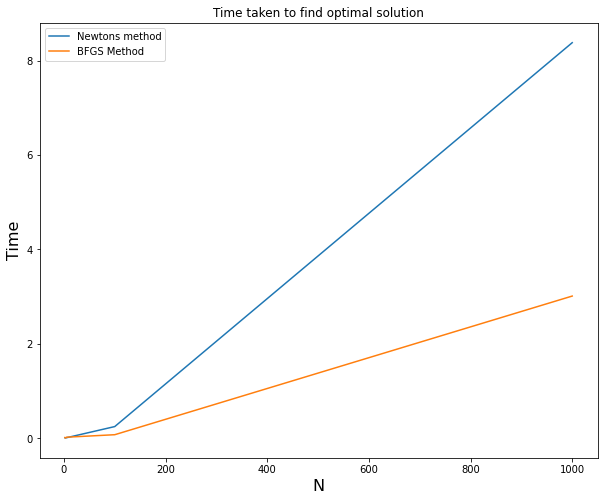

In [60]:

plt.subplots(figsize= (10,8))
plt.plot(n_arr,time_arr_newton ,label='Newtons method')
plt.plot(n_arr,time_arr ,label='BFGS Method')
plt.title('Time taken to find optimal solution')
plt.xlabel('N', fontsize=16)
plt.ylabel('Time', fontsize=16)
plt.legend()
plt.show()

***Remarks :*** *For the step length  =1.0, the optimal value cannot be find for n>=5 since the output is not converging. As we decrease the value of the step length we can find the value of the n for larger n. So instead of using step length 1, we are using step length of 0.4 and trying different values of n. But even with step length = 0.4, the BFGS method cannot be perfomed for n >500. Hence this is the result that we have got. But its clear from the graph that BFGS is performing better than newtons method*

$\large\textbf{Part 3 : Comparison of BFGS model (with backtracking line search) with Newton's method by time taken}$

$n \in \{500,1000,2500,5000,7500,10000\}$

$\min_{\mathbf{x} \in {\mathbb{R}}^n} f(\mathbf{x})  \ \ where, $ $f(\mathbf{x})=f(x_1,x_2,\ldots,x_n) = \sum_{i=1}^{n-1} \left [2(x_i^2 - x_{i+1})^2 + (x_i-1)^2) \right ]$

In [66]:

n_arr = np.array([2,3,5,10,100,1000,2500])
tol = 1e-9
alpha =0.9
rho = 0.5
gamma = 0.5

time_arr_bfgs = []
time_arr_newton = []


for n in n_arr:
  my_x = np.zeros(n)

  time_s = timer() 
  x,k = find_minimizer_BGFS(my_x,n,tol,BACKTRACKING_LINE_SEARCH,alpha,rho,gamma)
  time_e = timer()
  time_arr_bfgs.append(time_e - time_s)

  time_s = timer() 
  x,k = find_minimizer_Newtonmethod(my_x,n,tol,CONSTANT_STEP_LENGTH)
  time_e = timer()
  time_arr_newton.append(time_e - time_s)

  




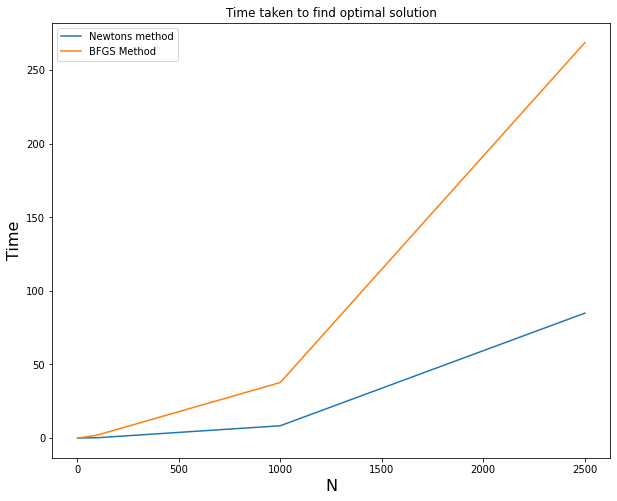

In [67]:

plt.subplots(figsize= (10,8))
plt.plot(n_arr,time_arr_newton ,label='Newtons method')
plt.plot(n_arr,time_arr_bfgs ,label='BFGS Method')
plt.title('Time taken to find optimal solution')
plt.xlabel('N', fontsize=16)
plt.ylabel('Time', fontsize=16)
plt.legend()
plt.show()

***Remarks :*** *We observe that here when we use BFGS method with backtracking, the time taken by newtwon methods is less than BFGS. Also the time taken by program to run at higher values is very large so we have only checked the time till n =2500 to get the patterna and understand it.*